# 第二次作业

**注意：**
1. 本次作业有三道题，总分按100分计，请在JupyterLab中使用*python*或者*R*在本文档中完成本次作业。
2. 请在做答时描述你的解题思路，并附上相应代码，我们将会根据结果的正确及清晰程度进行评分。
    + 请确保文字结果及代码清晰、易读。
    + 代码应有简要注释以及运行结果，运行结果应有相应的说明。请注意：注释允许使用中文/英文，可以使用co-pilot自动生成的注释，但要求对关键语句进行详细的注释，包括但不限于选择该语句的原因、参数设置的原因等。**代码的注释会纳入评分依据**
    + 图片结果应当有相应的标题。
3. 最终提交时请重命名此ipynb文件。将运行好的结果导出成html，并将相应的文件打包上传，文件命名格式请参照 “作业N_编程语言_本科⽣/研究⽣_姓名_学号 ”，使用英文和拼音，例：“homework2_python_undergraduate_zhangsan_1901111111”(本科生)或者 “homework2_python_postgraduate_zhangsan_1901111111”(研究生)。

*****

## 题目一

现在有一只鸽子，实验人员想要首先训练它在灯亮和铃响时啄食，并当训练完成后进一步进行训练使得鸽子只在灯亮时啄食，铃响时不啄食。实验员进行了100次训练使鸽子学会在灯亮和铃响时啄食，在每次训练开始时，可能出现灯亮、铃响、灯亮且铃响三种情况，紧接着鸽子有一定几率获得食物，通过记录鸽子在每次训练时啄食行为的次数，可以得到鸽子啄食行为随训练次数的变化情况。接着再进行了100次训练，只在灯亮的时候鸽子有一定几率获得食物，再次记录鸽子在每次训练时啄食行为的次数，同样得到鸽子啄食行为随训练次数的变化情况。

我们可以用Rescorla-Wagner模型（以下简称R-W模型）来模拟鸽子条件反射的建立过程，假设鸽子在每次训练内的啄食次数N服从泊松分布$ N \sim Possion(\lambda)$，其参数$\lambda$与两种刺激反射的链接强度$w$之间的关系为$\lambda = \max(100(w_1+w_2),5)$，实验开始时，两种刺激的初始连接强度均为$w_1 = w_2 = 0$。

### Q1
请读取实验数据'homework2_q1.csv'，可视化鸽子的啄食情况。

your answer here

##### 进行package导入和路径设置

In [1]:
# initiation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
import seaborn as sns
import constrNMPy
import os

plt.rcParams['font.sans-serif'] = ['Arial'] # set the font inline to Arial

# os.getcwd() 
os.chdir('/Users/abel/Desktop/Junior/CogMod/Assignments/H2') # change the working directory to the folder where the data is stored

# color pallette
[g,y,r,b,p,i,k] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']

In [2]:
# load the data from the csv file and take a look
dt = pd.read_csv('homework2_q1.csv', header = 0 ) # load the data from the csv file
[cues,rewards,responses] = [[dt['light'],dt['bell']],dt['reward'],dt['response']] # extract the data from the dataframe

df_vis = dt
df_vis.style.bar(subset=['response'], color=p, width=100)   # visualize the data with a bar plot indicating response


,trial,light,bell,reward,response
0,1,0,1,1,6
1,2,0,1,1,3
2,3,1,0,1,12
3,4,0,1,0,21
4,5,1,0,1,15
5,6,0,0,0,23
6,7,1,0,1,24
7,8,0,1,0,27
8,9,0,1,1,19
9,10,1,0,1,26


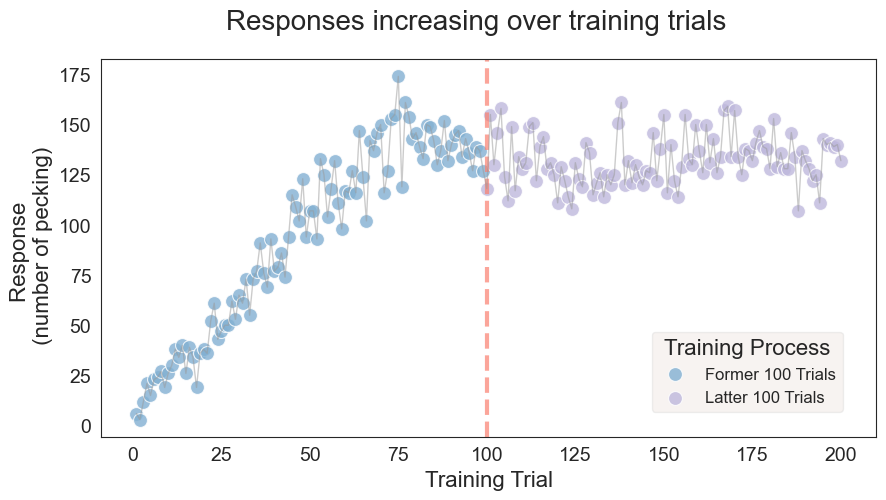

In [19]:
# plot the data
sns.set_style("white")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=100)

# Plot the first scatter plot on the left subplot
df_first = dt[dt['trial'] < 100];df_second = dt[dt['trial'] >= 100]
sns.scatterplot(x='trial', y='response', data=df_first, s=100, color=b, alpha=0.8, ax=axes, label='Former 100 Trials')
sns.scatterplot(x='trial', y='response', data=df_second, color=p, alpha=0.8, ax=axes, s=100, label='Latter 100 Trials',)
plt.legend( bbox_to_anchor=(0.7, 0.3), loc='upper left',
            fontsize=12, title='Training Process', title_fontsize=16, facecolor=i , framealpha=0.3)
axes.axvline(x=100, color= r, linestyle='--', linewidth=3, alpha = 0.7, label='Training 1')  # vertical line
plt.plot(dt['trial'], dt['response'], color = k, alpha = 0.5, linewidth = 1)
# Set titles and axis labels
fig.suptitle('Responses increasing over training trials', fontsize=20)
plt.xlabel('Training Trial', fontsize=16)
plt.ylabel('Response \n (number of pecking)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


### Q2
假设不同刺激对价值预测的影响独立，权重相同，且两种刺激的学习率$\alpha$相同。请用R-W模型对得到的啄食数据进行拟合，得到学习率$\alpha$，报告拟合结果，并画出拟合结果下两种刺激的$w$值随试次的变化情况。

your answer here

#### 首先我们根据题目要求生成对这个过程的模拟：
- 每一次训练过程中，根据刺激和奖赏的有无来通过预测误差更新刺激链接的强度，并且保存为一个列表，便于之后的输出
- 根据链接强度，每次模拟鸽子啄食的次数分布，倒推出每一试次的似然

rescorla_wagner()用来模拟这个过程，nll_rescorla_wagner()则只输出整个过程对数似然的负值

In [4]:
from scipy.stats import poisson

def rescorla_wagner(alpha, outcomes, response, cues):
    """
    Fit the Rescorla-Wagner model to a set of outcomes and cues.

    :param alpha: learning rate
    :param outcomes: a list of actual outcomes
    ：param response: a list of actual responses；
            response is generated by poisson distribution of lambda = max(100*(w_1*cues[0] + w_2*cues[1]),5)
    :param cues: a list of cues that predicted the outcomes； 
            cues[0] is the cue for the first outcome, cues[1] is the cue for the second outcome
    :return: negative log likelihood of the Rescorla-Wagner model
    """
    # Initialize the prediction error and the negative log likelihood
    error = np.zeros(len(outcomes))
    w_1 = [0] ; w_2 = [0] ; prediction = []; lams = [];
    nll = 0
    
    # Loop through each trial
    for t in range(len(outcomes)):
        
        # Calculate the prediction error
        prediction.append(cues[0][t] * w_1[t] + cues[1][t] * w_2[t])
        error[t] = outcomes[t] - prediction[t]
         
        # Calculate the negative log likelihood
        lams.append(max((100*(w_1[t] + w_2[t])),5))
        # lams.append(max((100*(w_1[t]*cues[0][t] + w_2[t]*cues[1][t])),5))
        prob = poisson.pmf(response[t],lams[t])
        nll += -np.log(prob)
        
        # Update the prediction of the outcome
        w_1.append(w_1[t] + alpha * error[t] * cues[0][t])
        w_2.append(w_2[t] + alpha * error[t] * cues[1][t])

    return nll, w_1, w_2, prediction,lams

def nll_rescorla_wagner(params, *args): # negative log likelihood
    return rescorla_wagner(params, *args)[0]


Based on the data, the estimated optimal learning rate is:  0.041060825990114194


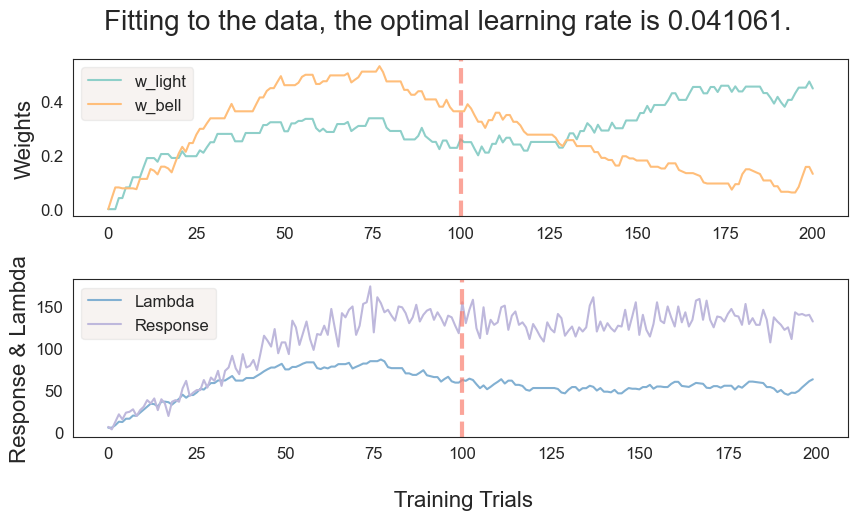

In [12]:
# Fit the model to the data
from scipy.optimize import minimize

initial_params = np.array([0.1])
result = minimize(nll_rescorla_wagner, initial_params, args=(rewards, responses, cues))
alpha = result.x[0]

[_,w_1,w_2,prediction,lams] = rescorla_wagner(alpha, rewards, responses, cues) 
print('''Based on the data, the estimated optimal learning rate is: ''', alpha)

# plot the data
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=100)

p1 = axes[0].plot(w_1, color=g, label='w_light')
p2 = axes[0].plot(w_2, color=y, label='w_bell')
axes[0].legend(loc='best', fontsize=12, facecolor=i , framealpha=0.3)
axes[0].axvline(x=100, color= r, linestyle='--', linewidth=3, alpha = 0.7, label='Training 1') # vertical line

axes[1].plot(lams, color=b, label='Lambda')
axes[1].plot(responses, color=p, label='Response')
axes[1].legend(loc='best', fontsize=12, facecolor=i , framealpha=0.3)
axes[1].axvline(x=100, color= r, linestyle='--', linewidth=3, alpha = 0.7, label='Training 1')

# set font size of axis labels
axes[0].tick_params(labelsize=12)
axes[1].tick_params(labelsize=12)

# set titles and axis labels
fig.suptitle('Fitting to the data, the optimal learning rate is %f.'%(alpha), fontsize=20)
axes[0].set_ylabel('Weights', fontsize=16)
axes[1].set_ylabel('Response & Lambda', fontsize=16)
axes[1].set_xlabel('\n Training Trials', fontsize=16)


plt.subplots_adjust(hspace=0.4)

plt.show()

## 题目二

在一个心理物理学实验中，主试向被试呈现不同强度的刺激，被试需要在他们认为有刺激出现的试次做出反应，对于不同的刺激强度$I$，被试反应的概率为($c_t=1$表示做出反应，$c_t=0$表示不反应)
$$P(c_t=1|I)=p_g+\frac{1-p_l-p_g}{1+exp(b(a-I))}$$

### Q1
    
假设模型参数取值为$p_g=0.2, p_l=0.2, b=0.2, a=20$,请画出被试反应概率随刺激强度变化的曲线($I\in[0,50]$)。然后随机生成150个试次的实验，每个试次的刺激强度独立，服从[0,50]上的均匀分布，并根据模型生成被试在实验中的反应。请在代码中指定随机种子为你的学号。

your answer here

In [ ]:
def weibull(I, pg, pl, b, a):
    return pg +(1 - pg - pl)/(1 + np.exp(-b*(I - a))) # the given weibull function

model_params = [0.2, 0.2, 0.2, 20] # initial set of the parameters



### Q2
    
请根据Q1中生成的实验数据，使用最大似然估计拟合模型参数，报告参数并画出拟合得到的模型反应概率随刺激强度变化的曲线，请注意参数的取值范围$p_g\in[0,1],p_l\in[0,1],b\in[0,\inf)$

your answer here

### Q3
    
请根据Q1中生成的实验数据，使用nonparametric bootstrap估计参数的95%置信区间(采样400次)
 

your answer here

### Q4
    
请根据Q1中生成的实验数据，使用parametric bootstrap估计参数的95%置信区间(采样400次)

your answer here

## 题目三

现有两枚骰子dice 1和dice 2，各有6个面（1, 2, 3, 4, 5, 6)，未知掷出各个面的概率是否均匀。对两枚骰子掷出不同点数的概率，有以下2种假设：
+ H1：两枚骰子相互独立，dice 1有$a$的概率掷出1，$(1 - a)/5$的概率掷出其他结果，dice 2有$b$的概率掷出6，$(1 - b)/5$的概率掷出其他结果，其中$a,\,b \in (0,1)$；
+ H2：两枚骰子不独立，有$c$的概率dice 1掷出1且dice 2掷出6，有$c$的概率dice 1掷出6且dice 2掷出1，有$(1 - 2c)/34$的概率掷出除一枚掷出1且另一枚掷出6之外的任意一种组合，其中$c \in (0,0.5)$。

### Q1
假设真实情况符合H1，$a = b = 1/3$。请固定随机种子为1，生成2组掷骰子的数据，第一组数据包含将2枚骰子一起投掷20次的结果，第二组数据包含将2枚骰子一起投掷1000次的结果。分别在两组数据上拟合H1和H2对应的模型，并比较AIC，报告最优的模型。

your answer here:

### Q2

比较在两组数据上的拟合结果，简述数据量对拟合结果中参数的影响，以及对模型比较的影响。

your answer here:

### Q3

分别假设骰子的真实情况符合H1和H2，当真实情况为H1时$a=b=1/3$，当真实情况为H2时$c=1/15$。分别在两种真实情况下，固定随机种子为2，生成20组掷骰子的数据，每组数据包含将2枚骰子一起投掷20次的结果，并在每种真实情况下采用leave-one-out cross-validation，比较上述H1和H2对应模型的结果。

定义 $$CV=-\sum_i\ln(f(y^i_{val}|\theta^{-i}_{cal}))$$
其中$f(.)$为likelihood function，$\theta^{-i}_{cal}$为calibration set的参数拟合结果，$y^i_{val}$表示validation set的数据, $i$表示validation set为第$i$组。

your answer here: